In [1]:
#@title Black Box_(install libraries)
%%capture
!pip install pingouin
!pip install autoreject
!pip install mne
!pip install mne_bids
!pip install mne_icalabel
!pip install pyprep
!pip install onnxruntime
!pip install python-picard
!pip install ipywidgets
!apt-get -qq update
!apt-get -qq install tree

In [2]:
#@title Import modules

%%capture
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne_bids
import autoreject
import seaborn as sns
import pyprep
import ipywidgets
import mne_icalabel

In [3]:
#@title Black Box_(download after ICLabel)
%%capture
!wget "https://drive.usercontent.google.com/download?id=1_GzO8rzA-gvgHWCrqCKMP0lm6KOmkLRn&export=download&confirm" -O aftericlabel.zip
!unzip -o aftericlabel.zip -d /content/
###Defining variables to read files in BIDS format with mne_bids.
cwd = os.getcwd()
bids_root = os.path.join(cwd, 'afterICLabel')
subjects=['23', '01', '02', '04', '05']
tasks=['default']
paths = mne_bids.find_matching_paths(
                            root=bids_root,
                            subjects=subjects, # Select sub to process
                            tasks=tasks, # Selecting all task by default
                            datatypes='eeg',
                            extensions='.fif' #Antes era .vhdr ¿Por qué cambió? ¡ Yo preguntaría eso !
                            )  #
eeg_labeled = {}
for path in paths:
    raw = mne_bids.read_raw_bids(path, extra_params= {
        'preload': True
        })
    sub= path.subject
    eeg_labeled[sub]=raw.copy()
eeg_labeled

<h2>Event Related Potentials</h2>

Ya podemos entrar al paradigma de los potenciales relacionados a eventos (ERP), seguramente ya tienen conocimiento de que un potencial relacionado al evento recibe su nombre por el tiempo que pasó desde el evento (el número en milisegundos) y el signo de la amplitud (P para positivo y N para negativo).  
<br>
La pregunta que podríamos hacer ahora es:
<br><br>

<center>

*Profe ¿Cómo encuentro un potencial relacionado a eventos en mi señal? ¿Cómo sé dónde está el evento? ¿Desde donde cuento?*

</center>

<br><br>
Bien, tenemos una primera palabra clave: el **evento**. Empecemos por encontrar dónde estarían guardados los eventos en nuestra señal.

<br>

<h2>Encontrar los eventos</h2>

<br>

Dentro de este archivo original, al estar en formato BIDS, tenemos dos objetos: **los eventos** y las **anotaciones relacionadas a los eventos**.  

<br>

Los eventos nos van a decir "aquí sucedió algo". En el archivo EEG tienen la forma de:
`[tiempo, 0, evento(número)]`

<br>

El número 0 solamente cambia cuando hay eventos que se traslapan, que son tan instantáneos que sucede uno sin que haya terminado el otro.
<br>

Las anotaciones relacionadas a eventos son información de "qué" sucedió. Normalmente están relacionadas con el id numérico del evento. Con tal que una anotación señala hacia un ID y nos da información de eso.


<table>
  <tr><th colspan="2" align="left">Función: <strong>mne.events_from_annotations</strong></strong>
  </strong></strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.events_from_annotations.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>

<br>
<tr><td>raw</td><td>El archivo de la señal continua. En este caso, está dentro de nuestros diccionarios. </td></tr>

<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Dos objetos, en nuestro caso los llamamos "event_list" y "annotations". El objeto "event_list" es un array/lista que contiene los eventos con la forma [tiempo, 0, evento(número)]. "annotations" es un diccionario que tiene la forma de { "Aquí sucedió algo": evento(número) }. Strings que conducen a los valores que son los eventos.
</table>






In [4]:
#Nuestro diccionario de archivos se llama ahora "eeg_labeled". Sigue teniendo como claves los ID y los eeg como valores.

event_list, annotations=mne.events_from_annotations(eeg_labeled['02'])
display(event_list)
print("")
display(annotations)

Used Annotations descriptions: [np.str_('1/WTrigger1/Critical/10/Amb/1/Diseinatzaile hauek esperantza handiz jaitsi dira sariketara/Abs'), np.str_('1/WTrigger1/Critical/102/Amb/1/Bezero haiek denbora luzez ezkutatu dira saltokian/Abs'), np.str_('1/WTrigger1/Critical/106/Amb/1/Kontseilari hauek pandemia egoeragatik arduratu dira prentsaurrean/Abs'), np.str_('1/WTrigger1/Critical/110/Amb/1/Ekologista horiek urduritasun itxuraz ailegatu dira kongresura/Abs'), np.str_('1/WTrigger1/Critical/114/Amb/1/Funtzionario haiek espero bezala atzeratu dira oporretan/Abs'), np.str_('1/WTrigger1/Critical/118/Amb/1/Aktore hauek guztiz burumakur bueltatu dira grabaziotik/Abs'), np.str_('1/WTrigger1/Critical/122/Amb/1/Zinegotzi horiek jaien astean murgildu dira Gasteizen/Abs'), np.str_('1/WTrigger1/Critical/126/Amb/1/Lider haiek urteetan zehar aberastu dira bilkurekin/Abs'), np.str_('1/WTrigger1/Critical/130/Amb/1/Youtuber hauek urtero bezala aztoratu dira partiduarekin/Abs'), np.str_('1/WTrigger1/Critica

array([[  16254,       0,     336],
       [  16916,       0,     691],
       [  17133,       0,    1075],
       ...,
       [1103638,       0,    1030],
       [1103854,       0,    1414],
       [1104071,       0,    1798]])

{np.str_('1/WTrigger1/Critical/10/Amb/1/Diseinatzaile hauek esperantza handiz jaitsi dira sariketara/Abs'): 1,
 np.str_('1/WTrigger1/Critical/102/Amb/1/Bezero haiek denbora luzez ezkutatu dira saltokian/Abs'): 2,
 np.str_('1/WTrigger1/Critical/106/Amb/1/Kontseilari hauek pandemia egoeragatik arduratu dira prentsaurrean/Abs'): 3,
 np.str_('1/WTrigger1/Critical/110/Amb/1/Ekologista horiek urduritasun itxuraz ailegatu dira kongresura/Abs'): 4,
 np.str_('1/WTrigger1/Critical/114/Amb/1/Funtzionario haiek espero bezala atzeratu dira oporretan/Abs'): 5,
 np.str_('1/WTrigger1/Critical/118/Amb/1/Aktore hauek guztiz burumakur bueltatu dira grabaziotik/Abs'): 6,
 np.str_('1/WTrigger1/Critical/122/Amb/1/Zinegotzi horiek jaien astean murgildu dira Gasteizen/Abs'): 7,
 np.str_('1/WTrigger1/Critical/126/Amb/1/Lider haiek urteetan zehar aberastu dira bilkurekin/Abs'): 8,
 np.str_('1/WTrigger1/Critical/130/Amb/1/Youtuber hauek urtero bezala aztoratu dira partiduarekin/Abs'): 9,
 np.str_('1/WTrigger1/Cr

Vemos que tenemos ya un array de eventos y un diccionario. El diccionario (estructura 'key':value) se conecta con los eventos en la forma de `'descripción': Evento`.

<br>

<center>

*Profe y ¿Qué son esas descripciones? No entiendo nada*  
･(>﹏<)

</center>

<br>

Tranquilos, para entender los eventos necesitamos un poco de contexto del estudio que proporcionó la data para este tutorial.

<br>

En la descripción, lo más notorio es una oración en vasco, como "*Influencerrak oso aberats egin dira azken urtean*". Estas oraciones son los estímulos usados en el estudio, alrededor de los cuales quiséramos saber si hay algún potencial.  

<br>

Tenemos también datos como `Filler` `Critical` `Amb` `Erg`.  

<br>

Una oración `Filler` es aquella que se presentó como "relleno" en el experimento. Es decir, no deberíamos encontrar necesariamente potenciales alrededor de ellas. En contraste está el `Critical`, que sí señala oraciones que posiblemente provocarían un potencial.

<br>

Lo que sigue son características de las oraciones. `Amb`/`Unamb` si la oración fue ambigua o no ambigua. `Erg`/`Abs` si la oración fue ergativa o absolutiva.

<br>

Lo más críptico podrían ser las etiquetas como `WTrigger1`. En realidad, es algo bastante simple; el experimento marcó un evento por cada palabra de la oración. El Trigger nos dice qué palabra fue: `WTrigger1` para la primera, `WTrigger2` para la segunda, etc.

<br>

Podemos explorar como se corresponden, en el output anterior encontramos que los primeros eventos eran:

<code>
[  16254,       0,     336],</code><br>
<code>[  16916,       0,     691],</code><br>
<code>[  17133,       0,    1075]
</code>

<br>

Si la lógica es `[tiempo, 0, evento]`, entonces los números 336, 691 y 1075 deberían ser las primeras 3 palabras de una misma oración. Podemos comprobar esto mediante un for loop en el diccionario `annotations`.

In [5]:
#Probemos el orden

values_to_check=[336, 691, 1075]

for key, value in annotations.items():
  if value in values_to_check:
    print(f"evento{value}: {key}")

evento336: 200/WTriggerFix/Critical/125/Amb/2/Politikari horiek guztiz ezkutuan dimititu dute amarruarengatik/Erg
evento691: 203/WTrigger1/Critical/125/Amb/2/Politikari horiek guztiz ezkutuan dimititu dute amarruarengatik/Erg
evento1075: 204/WTrigger2/Critical/125/Amb/2/Politikari horiek guztiz ezkutuan dimititu dute amarruarengatik/Erg


<h2> Epoching </h2>

Con los eventos, podemos pasar a crear epochs. Las epochs son como cortes en la señal de un EEG, los eventos nos van a indicar dónde cortamos. Por defecto, MNE interpretará que el evento siempre es el tiempo 0, así que nosotros tenemos que indicar el valor alrededor de 0, es decir, el tiempo antes y después en el que queremos el corte.

<br>

<figure style="text-align:left; margin:0;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/05_ai.png"
       alt="montaje"
       width="400">
  <figcaption style="margin-top:.25rem; color:#555;">Ejemplo fiel de científicos haciendo epochs.</figcaption>
</figure>




<br>

<table>
  <tr><th colspan="2" align="left">Función: <strong>mne.Epochs</strong></strong>
  </strong></strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.Epochs.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>

<br>
<tr><td>raw</td><td>El archivo de la señal continua. En este caso, está dentro de nuestros diccionarios. </td></tr>
<tr><td>events</td><td>Nuestro array de eventos con forma [1,0,1]. </td></tr>
<tr><td>events_id</td><td>Diccionario donde las keys son strings y los values event codes. </td></tr>
<tr><td>tmin</td><td>Si el evento es el tiempo 0, el "tmin" es el tiempo antes del 0. Marcamos el inicio del corte (normalmente es negativo). </td></tr>
<tr><td>tmax</td><td>Marcamos el fin del corte. </td></tr>
<tr><td>baseline</td><td>Se usa para aplicar una línea base. Por default la aplica, tenemos que decirle "None" para que no lo haga. </td></tr>
<tr><td>preload</td><td>Cargar el objeto en la memoria RAM. "True" porque queremos hacer operaciones con los epochs. </td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objeto nuevo mne.Epochs.
</table>

In [6]:
epochs={}
for sub, eeg in eeg_labeled.items():
    events_iteration, annotations_iteration= mne.events_from_annotations(eeg)
    #Construir epochs
    epochs_object= mne.Epochs(
        raw=eeg, #objeto de señal
        events=events_iteration, #
        event_id=annotations_iteration, #
        tmin=-0.1, #se delimita el corte en el tiempo
        tmax=1,
        baseline=None, #No aplicamos una linea base (modifica la epoch).
        preload=True #Importante si queremos seguir preprocesando (se carga el archivo en la RAM)
        )
    epochs[sub]=epochs_object

Used Annotations descriptions: [np.str_('1/WTrigger1/Critical/1/Amb/1/Aizkolari hauek gaur goizean iragan dira Bilbotik/Abs'), np.str_('1/WTrigger1/Critical/101/Amb/1/Sorgin horiek hiru orduz ezkutatu dira etxolan/Abs'), np.str_('1/WTrigger1/Critical/105/Amb/1/Aita haiek seme-alaben kustodiagatik arduratu dira gaur/Abs'), np.str_('1/WTrigger1/Critical/109/Amb/1/Testigu hauek oso bizkor ailegatu dira epaitegira/Abs'), np.str_('1/WTrigger1/Critical/113/Amb/1/Jakintsu horiek denbora luzez atzeratu dira bidaian/Abs'), np.str_('1/WTrigger1/Critical/117/Amb/1/Hippy haiek diru gutxirekin bueltatu dira Ameriketatik/Abs'), np.str_('1/WTrigger1/Critical/121/Amb/1/Haur hauek oporraldi garaian murgildu dira uztailean/Abs'), np.str_('1/WTrigger1/Critical/125/Amb/1/Politikari horiek guztiz ezkutuan aberastu dira amarruarekin/Abs'), np.str_('1/WTrigger1/Critical/129/Amb/1/Jokalari haiek hasi orduko aztoratu dira zelaian/Abs'), np.str_('1/WTrigger1/Critical/13/Amb/1/Ikasle hauek eguerdi inguruan erori

Además, en el experimento que intentamos replicar, las palabras clave son los verbos, que se encuentran siempre en la posición 5 `WTrigger5`.  

<br>

Para esto el objeto de eventos en MNE tiene un       <a href="https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.__getitem__"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      atributo</a> muy útil que nos permite acceder a los objetos mediante sus anotaciones, como si fuese un diccionario.

      
<br>

Entonces, llamar al objeto como `epoch['WTrigger5']` nos ayudará a recuperar todos los cortes alrededor de los verbos, en todas las oraciones, en todas las condiciones.

In [7]:
epochs_filtered={}
for sub, eeg in epochs.items():
    selected_epochs=eeg['WTrigger5']
    epochs_filtered[sub]=selected_epochs
epochs_filtered

{'01': <Epochs | 384 events (all good), -0.1 – 1 s (baseline off), ~25.9 MiB, data loaded,
  np.str_('205/WTrigger5/Critical/1/Amb/1/Aizkolari hauek gaur goizean iragan dira Bilbotik/Abs'): 1
  np.str_('205/WTrigger5/Critical/10/Unamb/4/Diseinatzaile honek esperantza handiz bozkatu du sariketan/Erg'): 1
  np.str_('205/WTrigger5/Critical/100/Amb/2/Abokatu hauek hamaikak aldera deklaratu dute epaitegian/Erg'): 1
  np.str_('205/WTrigger5/Critical/101/Amb/1/Sorgin horiek hiru orduz ezkutatu dira etxolan/Abs'): 1
  np.str_('205/WTrigger5/Critical/102/Unamb/4/Bezero hark denbora luzez argudiatu du saltokian/Erg'): 1
  np.str_('205/WTrigger5/Critical/103/Unamb/3/Bitartekari hau mehatxuen ondorioz ezkutatu da etxean/Abs'): 1
  np.str_('205/WTrigger5/Critical/104/Amb/2/Atleta horiek oraintxe bertan begiratu dute harmailarantz/Erg'): 1
  np.str_('205/WTrigger5/Critical/105/Amb/1/Aita haiek seme-alaben kustodiagatik arduratu dira gaur/Abs'): 1
  np.str_('205/WTrigger5/Critical/106/Unamb/4/Kontsei

Using matplotlib as 2D backend.


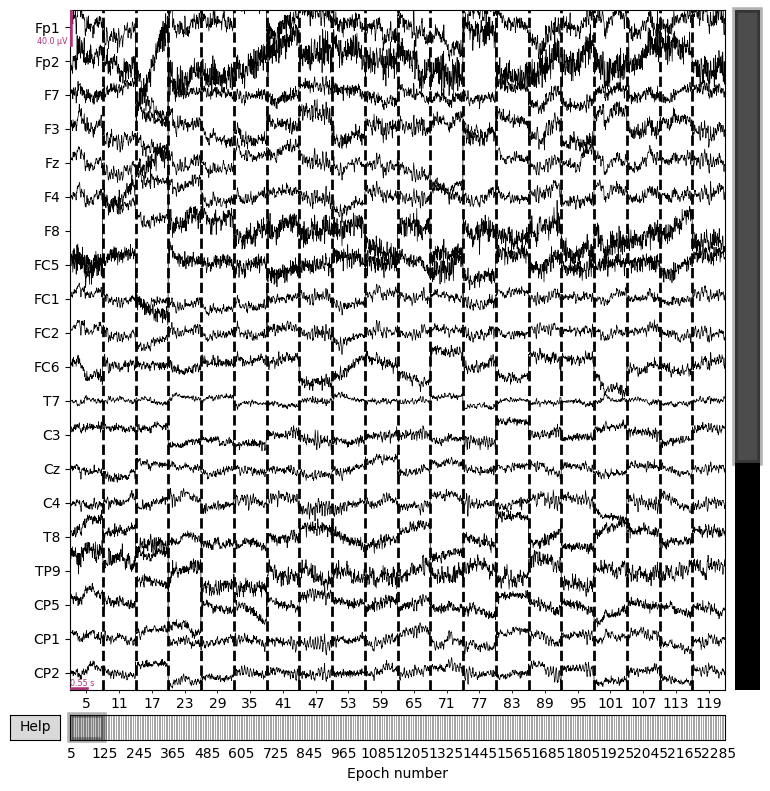

In [8]:
graph1=epochs_filtered['23'].plot()

<h2>Autoreject. La venganza del pre-procesado.</h2>

<br>

Cada decisión dentro el flujo de análisis puede cambiar la señal, así que podríamos decir que antes de obtener un plot o hacer estadística con los voltajes, seguimos procesando.

<br>

A nivel de épocas, también podemos limpiar la señal de artefactos. `Autoreject` es una herramienta integrada a MNE-Python. Su implementación generalmente es más fácil que el ICA, así que no demoraremos mucho en implementarla.

<br>

Lo que hace `Autoreject`, a grandes rasgos, es detectar epochs dañados en base a la amplitud o frecuencia de la señal. Internamente, usa métodos aleatorios para simular cómo sería una epoch "normal" con los datos que tenemos para tener un punto de comparación.

<br>

Además del rechazo, `Autoreject` puede rescatar las epochs dañadas con métodos como la **interpolación**, la cual consiste en reconstruir la señal de un canal en base a los canales cercanos. Antes de descartar una epoch, `Autoreject` siempre intenta rescatarla antes con la interpolación.

<br>

`Autoreject` está diseñado para sólo ser implementado sobre objetos mne.Epochs, en contraste al `ICA`, que puede ser utilizado en señales continuas o epocalizadas. Con todo lo que tenemos, estamos listos para pasar nuestras epochs tal y como están a `Autoreject`

<br>


<table>
  <tr><th colspan="2" align="left">Función: <strong>autoreject.Autoreject</strong>
  
  </strong>
      <a href="https://autoreject.github.io/stable/generated/autoreject.AutoReject.html#autoreject.AutoReject"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>n_interpolate</td><td>Cuántos canales usar para la interpolación. Usaremos [1,2,3,4] para que pruebe interpolar con 1, 2, 3 o 4 canales.</td></tr>
  <tr><td>random_state</td><td>El seed de aleatoriedad. 7 para la suerte.</td></tr>
  <tr><td>n_jobs</td><td>Núcleos para procesar en paralelo en la CPU. Para replicabilidad, no usamos procesamiento en paralelo.</td></tr>
  <tr><td>thresh_method</td><td>El método que queremos que use autoreject para calcular los umbrales de rechazo de las epochs "bayesian_optimization" por default. </td></tr>
  <tr><td>verbose</td><td>True or False. Determina si queremos que nos de outputs del progreso de la operación.</td></tr>
  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Objeto tipo autoreject.Autoreject.
  </td>
</table>


In [9]:
"""


epochs_autoreject={}
reject_logs={}
for sub, epochs_object in epochs_filtered.items():
    ar = autoreject.AutoReject(
    n_interpolate=[1, 2, 3, 4], #recommended in the documentation
    random_state=7, #Universo 7
    n_jobs=1, ### Esto es recomendado para la replicabilidad, por el parallel processing.
    verbose=False,
    thresh_method="bayesian_optimization")
    epochs_enhanced, reject_log = ar.fit_transform(epochs_object, return_log=True)

    if sub not in epochs_autoreject:
        epochs_autoreject[sub]={}
    epochs_autoreject[sub]=epochs_enhanced
    if sub not in reject_logs:
        reject_logs[sub]={}
    reject_logs[sub]=reject_log



"""

'\n\n\nepochs_autoreject={}\nreject_logs={}\nfor sub, epochs_object in epochs_filtered.items():\n    ar = autoreject.AutoReject(\n    n_interpolate=[1, 2, 3, 4], #recommended in the documentation\n    random_state=7, #Universo 7\n    n_jobs=1, ### Esto es recomendado para la replicabilidad, por el parallel processing.\n    verbose=False,\n    thresh_method="bayesian_optimization")\n    epochs_enhanced, reject_log = ar.fit_transform(epochs_object, return_log=True)\n\n    if sub not in epochs_autoreject:\n        epochs_autoreject[sub]={}\n    epochs_autoreject[sub]=epochs_enhanced\n    if sub not in reject_logs:\n        reject_logs[sub]={}\n    reject_logs[sub]=reject_log\n\n\n\n'

In [10]:
#@title Black Box_(download after AR)
%%capture
!wget "https://drive.usercontent.google.com/download?id=1ie6r3Xe-w_Zml7a5CKvhp4zHoAeWLUM2&export=download&confirm" -O afterAR.zip
!unzip -o afterAR.zip -d /content/

#Esta vez estamos leyendo objetos "epochs", por lo que la librería MNE-BIDS
#No será útil. En lugar de eso, lo haremos manual con "os" y lógica.
#Podemos asumir que ya sabemos dónde se encuentra cada archivo.
#Porque a pesar de que BIDS no lea epochs, sí las hemos guardado.
#En estructura MNE-BIDS.
eeg_dir = os.path.join(os.getcwd(), 'epochsafterAR')
epochs_autoreject = {}
subjects_to_load= ['01', '02', '04', '05', '23']

#iteramos en los sujetos.
for sub in subjects_to_load:
    subject_label=f"sub-{sub}"
    subject_path= os.path.join(eeg_dir, subject_label)
    if not os.path.exists(subject_path):
        print(f"Subject {subject_label} not found")
        continue
    #iteramos en los contenidos de los directorios de la ruta del sujeto.
    for fname in sorted(os.listdir(subject_path)):
        if fname.endswith('_epo.fif'):
            fname_no_ext = fname.replace('_epo.fif', '')
            subject_label, task_name = fname_no_ext.split('_')
            subject_id = subject_label.replace('sub-', '')
            task_name = task_name.replace('task-','')
            fpath = os.path.join(subject_path, fname)
            raw = mne.read_epochs(fpath, preload=True)
            print(f"{subject_label} loaded.")

            epochs_autoreject[sub] = raw

Luego de rechazar las epochs contaminadas, el siguiente paso es interpolar los canales que pudimos haber rechazado anteriormente (en el primer paso del pre-procesamiento). Para eso utilizaremos el método `.interpolate_bads` de los objetos mne.Epochs.

<br>


<table>
  <tr><th colspan="2" align="left">Método: <strong>.interpolate_bads</strong>
  <br><br>Objeto mne.Epochs
  </strong>
      <a href="https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.interpolate_bads"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>reset_bads</td><td>True or False. "True" deja de marcar a los canales como "bads" luego de interpolarlos. True en nuestro caso, porque los consideramos reparados.</td></tr>

  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Objeto tipo mne.Epochs con los canales interpolados.
  </td>
</table>

In [11]:
epochs_autoreject

{'01': <EpochsFIF | 248 events (all good), -0.1 – 1 s (baseline off), ~16.8 MiB, data loaded,
  '205/WTrigger5/Critical/1/Amb/1/Aizkolari hauek gaur goizean iragan dira Bilbotik/Abs': 1
  '205/WTrigger5/Critical/10/Unamb/4/Diseinatzaile honek esperantza handiz bozkatu du sariketan/Erg': 1
  '205/WTrigger5/Critical/100/Amb/2/Abokatu hauek hamaikak aldera deklaratu dute epaitegian/Erg': 1
  '205/WTrigger5/Critical/101/Amb/1/Sorgin horiek hiru orduz ezkutatu dira etxolan/Abs': 0
  '205/WTrigger5/Critical/102/Unamb/4/Bezero hark denbora luzez argudiatu du saltokian/Erg': 1
  '205/WTrigger5/Critical/103/Unamb/3/Bitartekari hau mehatxuen ondorioz ezkutatu da etxean/Abs': 1
  '205/WTrigger5/Critical/104/Amb/2/Atleta horiek oraintxe bertan begiratu dute harmailarantz/Erg': 1
  '205/WTrigger5/Critical/105/Amb/1/Aita haiek seme-alaben kustodiagatik arduratu dira gaur/Abs': 1
  '205/WTrigger5/Critical/106/Unamb/4/Kontseilari honek pandemia egoeragatik deklaratu du prentsaurrean/Erg': 1
  '205/WTr

In [12]:
epochs_interpolated={}
for sub, epochs_object in epochs_autoreject.items():
    epochs_copy=epochs_object.copy()
    epochs_copy=epochs_copy.interpolate_bads(reset_bads=True) #Ya no queremos que los canales estén marcados como dañados
    epochs_interpolated[sub]=epochs_copy

Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors


/tmp/ipython-input-1437283664.py:4: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_copy=epochs_copy.interpolate_bads(reset_bads=True) #Ya no queremos que los canales estén marcados como dañados
/tmp/ipython-input-1437283664.py:4: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_copy=epochs_copy.interpolate_bads(reset_bads=True) #Ya no queremos que los canales estén marcados como dañados
/tmp/ipython-input-1437283664.py:4: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_copy=epochs_copy.interpolate_bads(reset_bads=True) #Ya no queremos que los canales estén marcados como dañados


Setting channel interpolation method to {'eeg': 'spline'}.


/tmp/ipython-input-1437283664.py:4: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_copy=epochs_copy.interpolate_bads(reset_bads=True) #Ya no queremos que los canales estén marcados como dañados


Después, corregimos las epochs mediante la técnica de la línea base o `baseline`. Esta técnica, en sí, es muy intuitiva de entender.

<br>

Al examinar potenciales, una de las características que usamos para describirlos es ver si estos son Negativos o Positivos. Sin embargo, ya hemos discutido antes, en la parte de referenciar, lo relativa que puede ser una unidad de medición. Aquí es donde entra el `baseline`.

<br>


<center>

Se asume que se quiere estudiar la señal **inducida** por el evento. Entonces, una práctica es restar a esta señal el patrón basal (o por defecto) que tiene el participante, ya que este patrón no se relaciona con el evento específicamente, sino con sus características de sujeto.  

Esa señal a restar sería su `baseline`.

</center>

<br>

Es muy importante pensar en qué vamos a considerar como "señal basal". Normalmente, se considera que promediar un intervalo prudente antes del evento puede darnos idea de la actividad por defecto o la no relacionada con el evento; pero esto dependerá bastante de nuestro modelo experimental.

In [13]:
#@title Ｂｌａｃｋ　Ｂｏｘ＿(Baselines)


# function to draw signal
def draw_potential(t):
    y = 0.2
    y += 0.6 * np.exp(-((t + 0.3) ** 3) / (2 * 0.1 ** 3))   # before 0
    y += -0.8 * np.exp(-((t - 0.3) ** 2) / (2 * 0.08 ** 2)) # after 0
    return y

# function to draw correction. Takes the previous funct
def plot_potential(b_ini, apply_baseline):
    fs = 1000
    t = np.linspace(-0.4, 0.8, int(1.2 * fs))
    y_orig = draw_potential(t)
    y_corr = y_orig.copy()

    # b_ini should be <= 0
    b_ini = -b_ini
    b_ini = min(b_ini, 0)
    mask = (t >= b_ini / 1000) & (t < 0)
    baseline_mean = np.mean(y_corr[mask]) if np.any(mask) else 0.0
    print(f"Promedio de la señal del baseline ({b_ini} a 0 ms): {baseline_mean:.4f} µV")
    if apply_baseline:
        if np.any(mask):
            y_corr -= baseline_mean

    # Select which plot to show
    y_to_plot = y_corr if apply_baseline else y_orig

    # Plot
    fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
    fig.patch.set_facecolor("#0a0f1f")
    ax.set_facecolor("#0a0f1f")

    # Remnant of original signal
    if apply_baseline:
        ax.plot(t * 1000, y_orig, linewidth=1.5, color="#00ffd5", alpha=0.2, label="Original")

    # Actual signal
    ax.plot(t * 1000, y_to_plot, linewidth=2.2, color="#00ffd5", label="Corregida" if apply_baseline else "Original")

    ax.axvline(0, color="#ff6ec7", linestyle="--", linewidth=1)
    ax.axvspan(b_ini, 0, color="#ff6ec7", alpha=0.1)

    ax.set_xlim(-400, 800)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Tiempo (ms)", color="#cde3ff")
    ax.set_ylabel("Amplitud (µV)", color="#cde3ff")
    ax.set_title(
        f"Señal {'con' if apply_baseline else 'sin'} {f'baseline de {baseline_mean:.2f}µV ({b_ini} a 0 ms)' if apply_baseline else 'baseline (0.2 µV en tiempo 0)'}",
        color="#e6f0ff", pad=10
    )

    for spine in ax.spines.values():
        spine.set_color("#20345c")
        spine.set_linewidth(1.2)

    ax.tick_params(colors="#a8c8ff")
    ax.grid(True, which="both", linewidth=0.6, alpha=0.25)
    ax.legend(loc="upper right", facecolor="#0a0f1f", edgecolor="#20345c",
              labelcolor="#cde3ff", fontsize=8)

    #box
    if np.any(mask):
      ax.text(
          x=-100,  # center
          y=-0.2,
          s=f"Promedio: {baseline_mean:.3f} µV",
          color="#00ffd5",
          ha="center",
          va="center",
          fontsize=7,
          bbox=dict(facecolor="#0a0f1f", boxstyle="round,pad=0.2")
      )
    plt.tight_layout()
    plt.show()

# Widgets
ini_slider = ipywidgets.IntSlider(
    value=0, min=0, max=400, step=10, description='Baseline (ms)'
)

toggle_baseline = ipywidgets.ToggleButtons(
    options=[("Sin aplicar", False), ("Aplicada", True)],
    description="Corrección:",
)

ipywidgets.interactive(plot_potential, b_ini=ini_slider, apply_baseline=toggle_baseline)

interactive(children=(IntSlider(value=0, description='Baseline (ms)', max=400, step=10), ToggleButtons(descrip…

<table>
  <tr><th colspan="2" align="left">Método: <strong>.apply_baseline</strong>
  <br><br>Objeto mne.Epochs
  </strong>
      <a href="https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.apply_baseline"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>baseline</td><td>Recibe un "tuple" de dos valores. El primero es el tiempo mínimo y el segundo el tiempo máximo de la baseline. Forma un intervalo. En nuestro caso (-1.0, 0). Como es "tuple" va entre paréntesis. </td></tr>

  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Objeto tipo mne.Epochs con la corrección de línea base aplicada.
  </td>
</table>

In [14]:
epochs_baseline={}
for sub, epochs_object in epochs_interpolated.items():
    epochs_copy=epochs_object.copy()
    epochs_copy=epochs_copy.apply_baseline((-0.1,0))
    epochs_baseline[sub]=epochs_copy

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Ahora que ya tenemos las epochs con baseline e interpoladas, podemos explorarlas. Ya sabemos acceder al objeto mediante el diccionario, pero además, MNE Python nos permite seleccionar las epochs en base a las anotaciones que tiene, de manera parecida a un diccionario.

Probemos escogiendo los eventos que sean `'Critical'`, `'Amb'` y `'Abs'` a la vez. Para esto, podemos utilizar las propiedades del objeto mne.Epochs: Siempre que en las anotaciones originales, una string tenga "/", MNE considerará que ese "/" está separando valores independientes. Así, al llamar al objeto, podemos combinar los valores separados con "/" en las anotaciones, usando de igual forma "/".

Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated


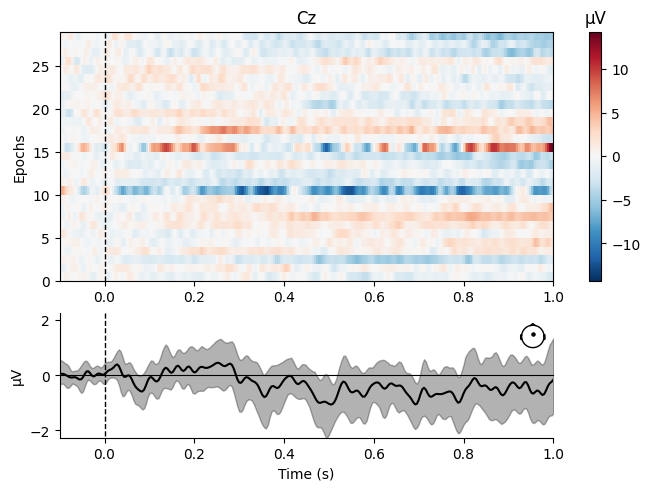

[<Figure size 640x480 with 4 Axes>]

In [15]:
epochs_baseline['01']['Critical/Amb/Abs'].plot_image(picks='Cz')

<h2>Potenciales evocados</h2>
<br>

Ya sabemos que las epochs son simplemente cortes ¿Cómo hacemos para obtener potenciales evocados?. En MNE-Python, los objetos mne.Evoked se crean a partir del promedio de epochs.

<br>

Esto quiere decir que un objeto evoked es simplemente varios cortes fusionados en uno. Sin embargo, para que tenga lógica, sólo deberíamos juntar los cortes de eventos parecidos entre sí, o que compartan alguna característica que se quiere explorar.
<br>

En este caso, intentaremos juntar las condiciones `Critical/Amb/Erg`, `Critical/Unamb/Erg`, `Critical/Amb/Abs` y `Critical/Unamb/Abs`. Lo que buscaremos, por tanto, es comparar las respuestas ante el la etiqueta de "Ambigüedad"

<br>

El evoked lo podemos obtener mediante el método `.average()` del objeto Epochs.Con este método, se combinarán las Epochs seleccionadas mediante el promedio de sus valores. Entonces, lo que resultará es que, por cada condición de interés, se seleccionarán las epochs de un participante que cumplan con el criterio de selección y se promediarán. Eso nos llevará a tener un evoked por cada condición, por participante.

<br>


<figure style="text-align:left; margin:0;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/07_ai.png"
       alt="montaje"
       width="400">
  <figcaption style="margin-top:.25rem; color:#555;">Científicos cognitivos creando objetos Evoked. Material real.</figcaption>
</figure>


<table>
  <tr><th colspan="2" align="left">Método: <strong>.average</strong>
  <br><br>Objeto mne.Epochs
  </strong>
      <a href="https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.average"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>







  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Objeto tipo       <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      mne.Evoked
  </a>. Se crea un nuevo objeto a partir de las epochs.
  </td>
</table>

<br>

Entonces, lo que tendríamos son evokeds por participantes, pero lo que también se quiere frecuentemente es analizar el efecto a través de todos los participantes. Para ello, deberíamos fusionar los evokeds de todos los participantes, y para esto tenemos el método `mne.grand_average()`, el cual se encarga específicamente de combinar evokeds.

<br>

<figure style="text-align:left; margin:0;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/08_ai.png"
       alt="montaje"
       width="400">
  <figcaption style="margin-top:.25rem; color:#555;">Comparación de condiciones.</figcaption>
</figure>

<br>


<table>
  <tr><th colspan="2" align="left">Función: <strong>mne.grand_average</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.grand_average.html#mne.grand_average"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  
  </th></tr>

  <tr><td>all_inst</td><td>Recibe una lista con las instancias a promediar. Puede recibir Evokeds, TFR (objetos que han calculado frecuencias), etc. </td></tr>






  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Retorna el promedio de los objetos brindados en un objeto del mismo tipo. En este caso, como daremos Evokeds, recibiremos otra       <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      mne.Evoked
  </a>.
  </td>
</table>

In [16]:
evokeds_sub={} #Evoked. Primer colapso / fusión de cortes
grand_averages={} #Grand averages. Segundo colapso / fusión de cortes. Juntamos los evokeds.
evokeds_list=[] #Esta es una lista que utilizaremos para guardar los evokeds a los que queremos hacer grand averages.
conditions=['Critical/Amb/Erg', #Definimos las condiciones que queremos. Recordemos que tenemos el atributo "Slice" en las epochs.
           'Critical/Amb/Abs',
           'Critical/Unamb/Erg',
           'Critical/Unamb/Abs']

for condition in conditions:
    for sub, epochs in epochs_baseline.items():
        epochs_copy=epochs.copy()#Copiamos por buena práctica
        epochs_copy=epochs_copy[condition].copy()
        evoked=epochs_copy.average() #Evoked
        if sub not in evokeds_sub:
            evokeds_sub[sub]={}
        evokeds_sub[sub][condition]=evoked
        evokeds_list.append(evoked) #guardamos todas las evoked de una sola condición en la lista.
    grand_averages[condition]=mne.grand_average(evokeds_list) #grand average
    evokeds_list.clear() #limpiamos la lista para no mezclarla con la próxima condición (que viene en la siguiente iteración del loop)

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


In [17]:
display(evokeds_sub['01'].keys())
grand_averages

dict_keys(['Critical/Amb/Erg', 'Critical/Amb/Abs', 'Critical/Unamb/Erg', 'Critical/Unamb/Abs'])

{'Critical/Amb/Erg': <Evoked | 'Grand average (n = 5)' (average, N=5), -0.1 – 1 s, baseline -0.1 – 0 s, 30 ch, ~106 KiB>,
 'Critical/Amb/Abs': <Evoked | 'Grand average (n = 5)' (average, N=5), -0.1 – 1 s, baseline -0.1 – 0 s, 30 ch, ~106 KiB>,
 'Critical/Unamb/Erg': <Evoked | 'Grand average (n = 5)' (average, N=5), -0.1 – 1 s, baseline -0.1 – 0 s, 30 ch, ~106 KiB>,
 'Critical/Unamb/Abs': <Evoked | 'Grand average (n = 5)' (average, N=5), -0.1 – 1 s, baseline -0.1 – 0 s, 30 ch, ~106 KiB>}

<h2>Evokeds y Grand Averages<h2>

<br>

Por conveniencia, los llamaremos distinto, aunque ya sabemos que son el mismo tipo de objeto; lo cual quiere decir que tienen los mismos métodos y atributos. Podemos empezar ploteando una representación visual de un grand_average mediante el método `.plot_joint`.

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot_joint</strong>
  </strong>
  <br>
  <br>
  Objeto mne.Evoked
      <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.plot_joint"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
  
  
  </th></tr>
  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>picks</td><td>Recibe una lista de strings con los nombres de los canales. Por default, grafica todos, pero esta vez seleccionaremos unos cuantos. </td></tr>






  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Objeto de matplotlib <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      Figure
  </a>. Es decir, un gráfico.
  </td>
</table>

No projector specified for this dataset. Please consider the method self.add_proj.


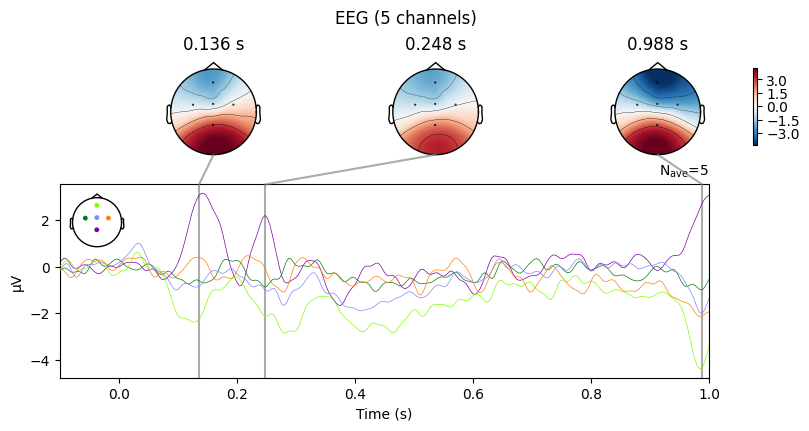

In [18]:
graph1=grand_averages['Critical/Amb/Erg'].plot_joint(
    picks=['Fz','Cz','C3', 'C4', 'Pz']
    )

Otra función útil cuando tenemos grand_averages por cada condición es `mne.viz.plot_compare_evokeds`. Esta visualización nos permite comparar dos evokeds en un solo gráfico. Como nosotros nuestros promedios de todos los participantes se han guardado en grand_averages (evokeds), podemos comparar en base a dichos objetos.

<br>

<table>
  <tr><th colspan="2" align="left">Función: <strong>mne.viz.plot_compare_evokeds</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html#mne.viz.plot_compare_evokeds"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
  
  
  </th></tr>
  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>evokeds</td><td>Recibe una lista con los evokeds a comparar o un diccionario con forma {"Nombre de la condición": objeto evoked}. En este caso, utilizaremos el diccionario para etiquetar condiciones. </td></tr>
  <tr><td>picks</td><td>Lista de canales cuya señal queremos plotear. Si son varios, se tiene que calcular una estimación (como la 'mean'). </td></tr>
  <tr><td>show_sensors</td><td>True or False para mostrar la imagen del montaje con el electrodo elegido. </td></tr>
  <tr><td>title</td><td>String para ponerle el título que queramos a la figura. </td></tr>
  <tr><td>truncate_xaxis</td><td> Parámetro de estilo para agregar el eje x de la plot. Si se ignora, es "False", pero escogeremos "True". </td></tr>
  <tr><td>truncate_yaxis</td><td> Parámetro de estilo para agregar el eje y de la plot. Si se ignora, es "False", pero escogeremos "True". </td></tr>
  <tr><td>axes</td><td>Guardar la figura en un gráfico más grande de matplotlib. Lo utilizaremos para después sombrearla. Si se ignora es None. No afecta en la visualización. </td></tr>
  <tr><td>show</td><td>True or False. Por default, en colab siempre se muestra aunque esté en "False". Sin embargo, si no está en "False" se mostrará dos veces. </td></tr>

  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Lista de figuras de objetos de matplotlib <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      Figure
  </a>. Es decir, gráficos.
  </td>
</table>

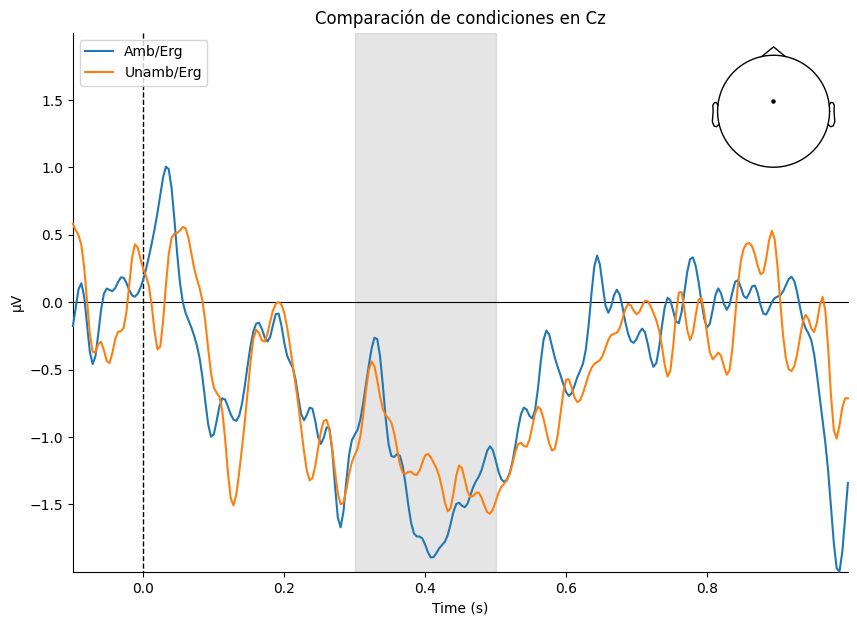

In [19]:
# Creamos nuestro diccionario primero
ambiguous_ergs={
    'Amb/Erg': grand_averages['Critical/Amb/Erg'],
    'Unamb/Erg': grand_averages['Critical/Unamb/Erg']
}

fig, ax = plt.subplots(figsize=(10,7)) #creamos una figura de matplot lib para guardar el gráfico.
#No es necesario, pero lo usaremos para sombrear.


mne.viz.plot_compare_evokeds(evokeds=ambiguous_ergs,
                             picks=['Cz'],
                             #combine='mean', #Si se agregan más electrodos, descomentar.
                             truncate_yaxis=False,
                             truncate_xaxis=False,
                             axes=ax,
                             title='Comparación de condiciones en Cz',
                             show_sensors='upper right',
                             show=False
                             )

#Agregamos un sombreado en el intervalo del N400.
#"ax" es donde está nuestra figura.
ax.axvspan(0.300, 0.500, color='gray', alpha=0.2, zorder=0)

Otra visualización que se suele usar es el `topomap`. Muestra la topografía de los sensores y un mapa de calor respecto a su activación. Para hacer un topomap, basta con llamar al método `.plot_topomap` del objeto evoked.

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot_topomap</strong>
  </strong><br><br>
  Objeto mne.Evoked
      <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.plot_topomap"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
  
  
  </th></tr>
  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>times</td><td>Puede ser un único número o array de números (se ponen entre paréntesis). Si se pasa más de un tiempo, se crea una topografía por tiempo elegido. </td></tr>
  <tr><td>average</td><td>El topomap estima cómo es la activación en un umbral de tiempo alrededor del "times" elegido. Este parámetro señala la amplitud de ese umbral. </td></tr>
  <tr><td>ch_types</td><td>En nuestro caso 'eeg'. </td></tr>
  <tr><td>size</td><td>Tamaño del gráfico. En nuestro caso 2. </td></tr>

  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Objeto de matplotlib <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      Figure
  </a>. Es decir, gráfico.
  </td>
</table>

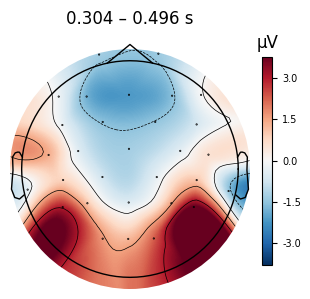

In [20]:
graph1=grand_averages['Critical/Amb/Erg'].plot_topomap(times=0.40,
                                                average=0.2,
                                                ch_type='eeg',
                                                size=2
                                                )
                                                # Con estos parámetros intentamos explorar el intervalo del N400

In [21]:
grand_averages

{'Critical/Amb/Erg': <Evoked | 'Grand average (n = 5)' (average, N=5), -0.1 – 1 s, baseline -0.1 – 0 s, 30 ch, ~106 KiB>,
 'Critical/Amb/Abs': <Evoked | 'Grand average (n = 5)' (average, N=5), -0.1 – 1 s, baseline -0.1 – 0 s, 30 ch, ~106 KiB>,
 'Critical/Unamb/Erg': <Evoked | 'Grand average (n = 5)' (average, N=5), -0.1 – 1 s, baseline -0.1 – 0 s, 30 ch, ~106 KiB>,
 'Critical/Unamb/Abs': <Evoked | 'Grand average (n = 5)' (average, N=5), -0.1 – 1 s, baseline -0.1 – 0 s, 30 ch, ~106 KiB>}

In [22]:
#@title Ｂｌａｃｋ　Ｂｏｘ (＞Ｅｘｐｌｏｒｅ)
def plot_topomap(condition, times, average):
    obj = grand_averages[condition]
    obj.plot_topomap(
        times=times,
        average=average,
        ch_type='eeg',
        size=4,
        res=128,
        vlim=(-2,2)
        )
toggle_condition=ipywidgets.ToggleButtons(
    options=['Critical/Amb/Erg', 'Critical/Amb/Abs', 'Critical/Unamb/Erg', 'Critical/Unamb/Abs'],
    description='Condición:',
    disabled=False,
    button_style='',
    style={'button_width':'10em'},
)
label = ipywidgets.HTML(
    value="<div style='font-size:18px; text-align:left;'>Exploremos qué sucede en cada condición:</div>"
)
ini_slider = ipywidgets.FloatSlider(
    value=0, min=0, max=1, step=0.05, description='Tiempo (ms)'
)

ave_slider = ipywidgets.FloatSlider(
    value=0.1, min=0.01, max=1, step=0.05, description='Umbral (ms)'
)

plot_widget = ipywidgets.interactive(
    plot_topomap,
    condition=toggle_condition,
    times=ini_slider,
    average=ave_slider
)

ipywidgets.VBox([label, plot_widget])


<h2>Obtener datos de los objetos<h2>


Adicionalmente, podemos obtener los datos de cualquier objeto evoked o epoch con el método `.to_data_frame` Esto es sumamente necesario para realizar comparaciones estadísticas. Los datos se devuelven en una tabla de pandas.



<table>
  <tr><th colspan="2" align="left">Método: <strong>.to_data_frame</strong></strong>
  </strong>
  <br><br>
  Objeto mne.Evoked</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.to_data_frame"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>

<br>


<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Tabla de pandas dataframe.
</table>

In [23]:
print("Dataframe Evoked sub-01")
evo_sub_01_dataframe=evokeds_sub['01']['Critical/Amb/Erg'].to_data_frame()
display(evo_sub_01_dataframe)
print("Dataframe Grand Average")
grandav_amberg_dataframe=grand_averages['Critical/Amb/Erg'].to_data_frame()
display(grandav_amberg_dataframe)

Dataframe Evoked sub-01


,time,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,CP6,P7,P3,Pz,P4,P8,O1,Oz,O2,TP10
0,-0.100,0.482176,0.321461,0.574696,0.542849,1.200865,0.429074,0.307062,0.237299,0.707296,...,-0.874008,-0.494966,-0.731237,-0.247391,0.012392,-0.375705,-0.929214,-0.351305,-0.169844,-0.032689
1,-0.096,0.199175,0.173064,0.478995,0.217606,0.933303,0.260425,0.214626,0.261343,0.358719,...,-0.701426,-0.520556,-0.275245,0.027158,-0.023377,-0.541244,-0.638217,0.044472,-0.063817,-0.085426
2,-0.092,-0.037440,0.028529,0.126042,-0.041478,0.667857,0.177103,0.156533,0.079412,0.012480,...,-0.413851,-0.627453,0.099139,0.343578,0.142749,-0.548007,-0.334035,0.444563,0.077750,-0.062540
3,-0.088,-0.200734,-0.113115,-0.294585,-0.125204,0.483067,0.168289,0.154792,-0.157879,-0.137987,...,-0.290762,-0.735707,0.327058,0.550663,0.451814,-0.526798,0.050518,0.763071,0.189607,0.019592
4,-0.084,-0.277949,-0.240432,-0.549764,0.035639,0.406165,0.186450,0.177054,-0.244239,-0.026283,...,-0.376021,-0.897675,0.428802,0.546340,0.777863,-0.573878,0.430721,0.873200,0.198262,0.128093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0.984,-1.452377,-1.358751,-0.970375,-1.075992,-4.989860,-2.208945,-1.194983,-0.602621,-3.110899,...,1.027215,-1.366661,4.148611,1.929768,5.516185,1.745352,6.058139,4.161156,2.227720,0.003058
272,0.988,-0.895390,-1.056756,-0.617493,-0.741207,-4.706221,-2.060720,-1.379431,-0.315081,-3.012124,...,0.327166,-1.791992,3.965279,2.046064,5.180754,0.940168,5.444774,3.813074,1.827726,0.011262
273,0.992,-0.362809,-0.650049,-0.238820,-0.408858,-4.182908,-1.819603,-1.532177,0.043976,-2.662108,...,-0.543413,-2.594324,3.786407,2.142842,4.787675,0.006765,4.565217,3.392548,1.376894,0.018626
274,0.996,-0.087129,-0.359702,-0.000404,-0.110478,-3.505652,-1.523764,-1.458118,0.267639,-2.132383,...,-1.006564,-3.527247,3.489842,2.165422,4.421032,-0.660034,3.603881,2.976952,1.062836,0.053100


Dataframe Grand Average


,time,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,CP6,P7,P3,Pz,P4,P8,O1,Oz,O2,TP10
0,-0.100,-0.001707,0.064656,0.117954,-0.156833,0.046397,-0.108773,0.128938,0.024954,-0.146434,...,-0.018773,0.494929,0.143323,0.138871,0.363663,-0.018358,0.127656,-0.215789,-0.011989,-0.169347
1,-0.096,0.034609,-0.054825,0.111108,-0.217168,0.081145,-0.069809,0.008005,0.048297,-0.109204,...,-0.046071,0.268060,0.151197,0.293335,0.401039,-0.200055,0.048663,-0.136534,-0.016938,-0.022484
2,-0.092,0.169927,-0.166939,0.116656,-0.127624,0.194774,-0.057989,-0.093551,0.031920,-0.025662,...,-0.130172,-0.063138,0.115968,0.368954,0.385540,-0.273366,-0.007287,0.028098,0.071165,0.122933
3,-0.088,0.286302,-0.096634,0.130663,0.022298,0.287115,-0.119791,-0.032218,-0.026961,0.027237,...,-0.259169,-0.313392,0.051080,0.324883,0.325691,-0.212462,0.025189,0.230426,0.227738,0.164989
4,-0.084,0.312604,0.144024,0.140935,0.122458,0.273505,-0.214815,0.206698,-0.094790,-0.007159,...,-0.334355,-0.385687,-0.018443,0.187921,0.277436,-0.046546,0.117318,0.357001,0.369497,0.053392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0.984,-3.416497,-2.846502,-1.931688,-3.154600,-4.384864,-3.450787,-2.073981,-1.512689,-2.915841,...,1.384951,4.855396,4.452426,2.492020,4.061240,4.406340,3.325127,3.735488,3.996962,-1.909665
272,0.988,-3.257495,-2.785164,-1.819678,-3.043573,-4.322880,-3.417292,-2.046188,-1.422288,-2.860359,...,1.194888,4.283318,4.169191,2.726262,4.167348,4.246734,3.015099,3.834960,4.118634,-1.934465
273,0.992,-2.995466,-2.567084,-1.697514,-2.874984,-4.098509,-3.247795,-2.003299,-1.309942,-2.606520,...,1.004102,3.551456,3.801018,2.895417,4.155431,4.001255,2.423736,3.710404,4.036022,-1.796576
274,0.996,-2.706232,-2.290626,-1.548190,-2.662671,-3.753422,-3.006299,-1.936315,-1.177936,-2.218116,...,0.855052,2.712056,3.402480,3.002129,3.992123,3.686258,1.675065,3.430561,3.781355,-1.558711


<h2>Frecuencias de onda<h2>

<br>

Otro de los análisis comunes son los relacionados a las frecuencias de onda o bandas alfa, beta, etc. Lo primero para adentrarnos en el tema es entender que ya no nos referimos a la amplitud (µV), sino a la frecuencia (Hz).

<br>

La lógica de los cortes que hemos aprendido con los evokeds y epochs es transferible. Al final, no están cambiando la señal; sólo midiendo momentos que contienen información de interés.

<br>

¿Cuál es esa información? En el paradigma de ERP, está relacionada a la amplitud. En el paradigma de frecuencias, está relacionada a Hz.

<br>

Probemos accediendo a nuestro objeto evoked `grand_averages['Critical/Amb/Abs']`. Este tiene una propiedad que es `.compute_psd`, la cual calculará las frecuencias de onda y la actividad en cada una. La intensidad de actividad en una frecuencia el nombre de `power` y se relaciona con la amplitud en la medida de que el power es `V²/Hz`.


<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.compute_psd</strong></strong>
  </strong>
  <br><br>
  Objeto mne.Evoked</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.compute_psd"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

<br>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objeto tipo       <a href="https://mne.tools/stable/generated/mne.time_frequency.Spectrum.html#mne.time_frequency.Spectrum"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      Spectrum</a>. Es el objeto después de computar el Power Spectral Density.
</table>

<br>

Al crear nuestro objeto Spectrum, también podemos llamar métodos familiares como `.plot_topomap` o `.plot`. El primer método nos dará una topografía en donde veremos la distribución en nuestro montaje del poder de la señal en las distintas bandas que se han relacionado con señales del cerebro.

<br>
<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot_topomap</strong></strong>
  </strong>
  <br><br>
  Objeto mne.Spectrum</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.time_frequency.Spectrum.html#mne.time_frequency.Spectrum.plot_topomap"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
</th></tr>
<tr><td>dB</td><td>True or False. Determina si plotear las unidades de medida de decibeles o no. </td></tr>

<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
  Objeto de matplotlib <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      Figure
  </a>. Es decir, gráfico.
  </td>
</table>
<br>

Por otra parte `.plot` nos dará una figura en donde veremos el poder total de cada una de las bandas.

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot</strong></strong>
  </strong>
  <br><br>
  Objeto mne.Spectrum</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.time_frequency.Spectrum.html#mne.time_frequency.Spectrum.plot"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
</th></tr>
<tr><td>axes</td><td>Utilizaremos esto para colocarlo en una figura matplotlib y reducir el límite del eje y. </td></tr>

<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
  Objeto de matplotlib <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      Figure
  </a>. Es decir, gráfico.
  </td>
</table>

    Using multitaper spectrum estimation with 7 DPSS windows


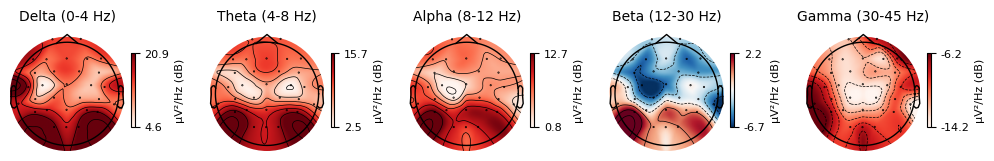

In [24]:
spectrum=grand_averages['Critical/Amb/Erg'].compute_psd() #Nuestro objeto evoked. Calculamos el PSD y lo guardamos en 'spectrum'
graph1=spectrum.plot_topomap(dB=True)

Plotting power spectral density (dB=True).


(0.0, 60.0)

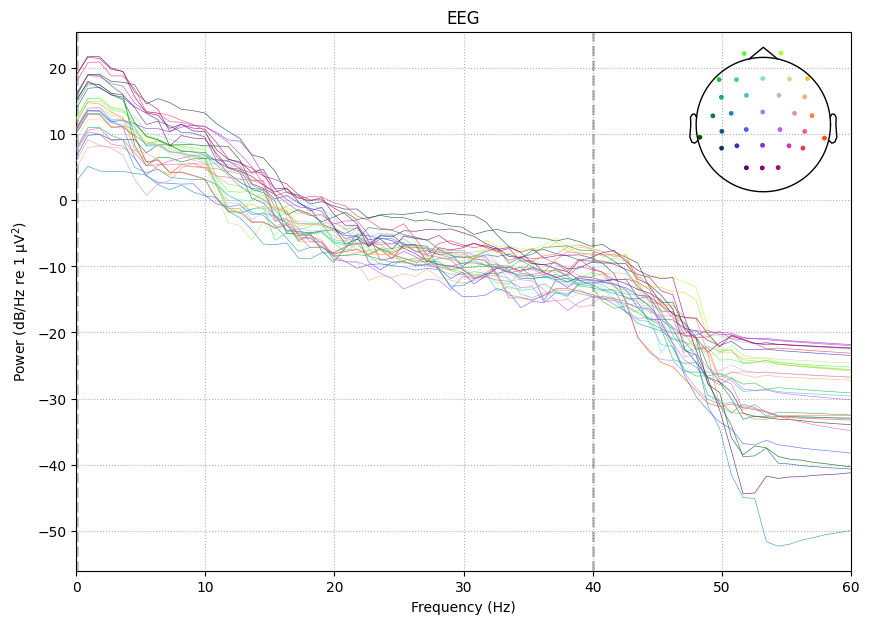

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
spectrum.plot(axes=ax)
ax.set_xlim(0,60)

<h2>Explorar los cambios de en las frecuencias durante el tiempo<h2>

En el paper que estamos usando de base, una hipótesis consistía en ver el cambio de ciertas frecuencias en el tiempo. Es decir, cómo las frecuencias cambiaban alrededor del evento. Para eso, tenemos que computar la representación tiempo-frecuencia (TFR).

<br>

Nosotros ya hemos segmentado la data en Epochs y Evokeds. Es decir, tenemos los tiempos que nos importan y la data alrededor de ellos. En este sentido, podemos calcular la TFR a partir de estos objetos, con el método `.compute_tfr`. En esta ocasión, computaremos la TFR a partir de los evokeds.

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.compute_tfr</strong></strong>
  </strong>
  <br><br>
  Objeto mne.Evoked</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.compute_tfr"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
</th></tr>
<tr><td>method</td><td>El método para computar las TFR. Por simpleza, seleccionaremos "morlet".  </td></tr>
<tr><td>freqs</td><td>Información sobre el rango de frecuencias que queremos obtener en el cálculo. Tiene forma de array (fmínima, fmáxima, salto entre frecuencias). Por ejemplo, de 1 a 2Hz, con un salto de 0.5, obtendríamos: 1, 1.5, 2. </td></tr>
<tr><td>picks</td><td>Canales de datos a tomar en cuenta en el cálculo. "eeg" en nuestro caso. </td></tr>
<tr><td>output</td><td>La magnitud que queremos calcular. En nuestro caso es "power". </td></tr>
<tr><td>n_cycles</td><td>¿Cuántas oscilaciones por frecuencia tendrán que ver nuestras ventanas? En nuestro caso: 3. Valores más altos amplían la ventana (distingue mejor entre frecuencias), pero pierde precisión de cuándo ocurre un cambio. </td></tr>
<tr><td>decim</td><td>Luego del cálculo TFR, podemos elegir cuántas muestras del cálculo queremos como retorno. decim=1 es 1/samplingfreq (1/250Hz). Con 12, nuestro output dibujará un nuevo dato cada 50ms aproximadamente. </td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
  Objeto AverageTFR <a href="https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne.time_frequency.AverageTFR"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      mne.time_frequency.AverageTFR
  </a>. Es un objeto con información de la transformación a tiempo-frecuencia.
  </td>
</table>


In [26]:
frequencies = np.arange(4.5, 40, 0.5)
tfr_subs={}
conditions=['Critical/Amb/Erg',
           'Critical/Amb/Abs',
           'Critical/Unamb/Erg',
           'Critical/Unamb/Abs']

for condition in conditions:
    for sub in evokeds_sub.keys(): #Ojo que estamos ahora iterando en las keys. Dentro de cada key hay un diccionario.
        tfr=evokeds_sub[sub][condition].copy()
        tfr=tfr.compute_tfr(
                            method='morlet',
                            freqs=frequencies,
                            picks='eeg',
                            output='power',
                            n_cycles=3, #cuantos siglos quiero ver por frecuencia.
                            decim=12 #cuantos puntos quiero de salida. 1/250Hz es 4ms. decim=1 es un punto de la señal, o sea 4ms.
                            )
        if sub not in tfr_subs:
            tfr_subs[sub]={}
        tfr_subs[sub][condition]=tfr

In [27]:
tfr_subs

{'01': {'Critical/Amb/Erg': <Power Estimates from Evoked (nave=30), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>,
  'Critical/Amb/Abs': <Power Estimates from Evoked (nave=29), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>,
  'Critical/Unamb/Erg': <Power Estimates from Evoked (nave=33), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>,
  'Critical/Unamb/Abs': <Power Estimates from Evoked (nave=30), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>},
 '02': {'Critical/Amb/Erg': <Power Estimates from Evoked (nave=40), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>,
  'Critical/Amb/Abs': <Power Estimates from Evoked (nave=39), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>,
  'Critical/Unamb/Erg': <Power Estimates from Evoked (nave=

<br>


Como hemos sacado un TFR de nuestro Evoked, tenemos la frecuencia fase-bloqueada.

<br>

<center>

*¿Cómo que fase-bloqueada, profe? ¡¿Por qué se inventa palabras y espera que entienda?!*

</center>

<br>

¡Achachay! ¡Qué buena pregunta! Pero esa es una caja negra para otra historia. Lo que nos servirá saber por ahora es que el que esté fase-bloqueadas nos sirve para ver las frecuencias relacionadas a los eventos (ERF).

<br>

Para esto, tendremos que seguir pasos parecidos a los de el paradigma ERP. Antes de promediar entre todos los sujetos, debemos aplicar un `baseline`. Recordemos que en el paradigma ERP, el baseline era el promedio en la amplitud, pero ahora estamos analizando frecuencias: **el baseline de frecuencias es distinto al baseline de amplitud**.

<br>

El objetivo es el mismo, pero los valores que nos importan son otros. Esta vez nos ayudaremos de nuevo del método `.apply_baseline`, que también existe en los objetos `AverageTFR`.

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.apply_baseline</strong></strong>
  </strong>
  <br><br>
  Objeto mne.time_frequency.AverageTFR</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne.time_frequency.AverageTFR.apply_baseline"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
</th></tr>
<tr><td>baseline</td><td>De nuevo una tupla. Esta vez es la tupla de la frecuencia mínima y la máxima. En nuestro caso utilizaremos la longitud previa de nuestra evoked (-0.1, 0)  </td></tr>
<tr><td>mode</td><td>En el paradigma ERP, es por defecto "mean" para el promedio de los valores. Como en TFR tenemos "potencias" por frecuencias, los cálculos son más complejos. Utilizaremos "logratio".  </td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
  Objeto AverageTFR <a href="https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne.time_frequency.AverageTFR"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      mne.time_frequency.AverageTFR
  </a>. El objeto con la corrección realizada.
  </td>
</table>

<br>


Finalmente promediamos todos los AverageTFR que tenemos, así como hicimos con los objetos Evokeds. Recordemos cuando revisamos la función `mne.grand_average` pudimos ver que recibe varios tipos de objetos. Esta la función que utilizaremos de nuevo.


<br>


<table>
  <tr><th colspan="2" align="left">Función: <strong>mne.grand_average</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.grand_average.html#mne.grand_average"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  
  </th></tr>

  <tr><td>all_inst</td><td>Recibe una lista con las instancias a promediar. Puede recibir Evokeds, TFR (objetos que han calculado frecuencias), etc. </td></tr>






  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Retorna el promedio de los objetos brindados en un objeto del mismo tipo. En este caso daremos y recibiremos       <a href="https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne.time_frequency.AverageTFR"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      mne.time_frequency.AverageTFR
  </a>.
  </td>
</table>

In [28]:
tfr_grand_averages={}
tfr_list_to_average=[]
conditions=['Critical/Amb/Erg',
           'Critical/Amb/Abs',
           'Critical/Unamb/Erg',
           'Critical/Unamb/Abs']


for condition in conditions:
  for sub in tfr_subs.keys():
    tfr_object=tfr_subs[sub][condition].copy()
    tfr_object=tfr_object.apply_baseline(baseline=(-0.1, -0.0), mode='logratio')
    tfr_list_to_average.append(tfr_object)
  subs_tfr_average=mne.grand_average(tfr_list_to_average)
  tfr_grand_averages[condition]=subs_tfr_average
  tfr_list_to_average.clear()

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Identifying common channels ...
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Identifying common channels ...
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Identifying common channels ...
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (

In [29]:
tfr_grand_averages

{'Critical/Amb/Erg': <Power Estimates from Evoked (nave=5), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>,
 'Critical/Amb/Abs': <Power Estimates from Evoked (nave=5), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>,
 'Critical/Unamb/Erg': <Power Estimates from Evoked (nave=5), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>,
 'Critical/Unamb/Abs': <Power Estimates from Evoked (nave=5), morlet method | 30 channels × 71 freqs × 23 times, 4.5 - 39.5 Hz, -0.10 - 0.96 s, 424 KiB>}

<h2>Visualizar frecuencias<h2>

<br>

Con todos los cálculos hechos, podemos explorar las frecuencias a través del tiempo con métodos parecidos a los objetos evokeds. Exploraremos `.plot` y `.plot_topomap`.

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot</strong></strong>
  </strong>
  <br><br>
  Objeto mne.time_frequency.AverageTFR</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne.time_frequency.AverageTFR.plot"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
</th></tr>
<tr><td>combine</td><td>Combina los datos de los canales ya normalizados y pasados por baseline. Si ignoramos este parámetro, MNE nos dará una plot por canal(electrodo). Le daremos por ahora "mean" para visualizar.</td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
  Lista de objetos de matplotlib <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      Figure
  </a>. Es decir, gráficos.
  </td>
</table>


<br>

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot_topomap</strong></strong>
  </strong>
  <br><br>
  Objeto mne.time_frequency.AverageTFR</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne.time_frequency.AverageTFR.plot_topomap"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
</th></tr>
<tr><td>tmin</td><td>Tiempo desde el cual queremos empezar a visualizar. Se promediará lo encontrado desde este tiempo hasta el tmax.</td></tr>
<tr><td>tmax</td><td>Tiempo máximo hasta el cual considerar la estimación de poder. Junto con tmin, cortan un intervalo</td></tr>
<tr><td>fmin</td><td>Frecuencia mínima desde la cual se quieren promediar los datos.</td></tr>
<tr><td>fmax</td><td>Frecuencia máxima hasta la que se quieren promediar los datos.</td></tr>
<tr><td>cbar_fmt</td><td>Parámetro de la barra de color de la topografía. Determina cuántos decimales mostrar. Para legibilidad colocaremos '%.2f' para tener máximo dos decimales.</td></tr>
<tr><td>size</td><td>Tamaño de la topografía. En nuestro caso, probemos con 4.</td></tr>



<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>
<td colspan="2">
  Objeto de matplotlib <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      Figure
  </a>. Un gráfico.
  </td>
</table>

No baseline correction applied


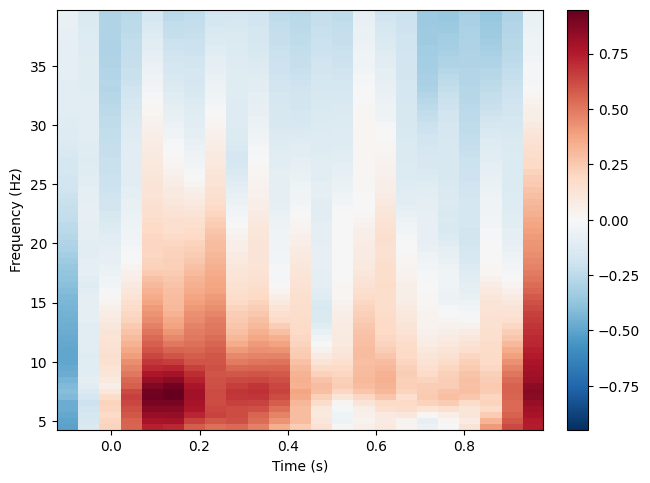

In [30]:
graph1=tfr_grand_averages['Critical/Amb/Erg'].plot(
                                                   tmin=-0.1,
                                                   tmax=1,
                                                   combine='mean'
                                                   )

No baseline correction applied


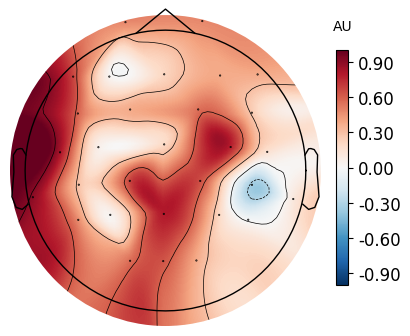

In [31]:
graph1=tfr_grand_averages['Critical/Amb/Erg'].plot_topomap(
    tmin=0.35,
    tmax=0.45,
    fmin=8,
    fmax=12,
    vlim=(-1.0, 1.0),
    cbar_fmt='%.2f',
    size=4
    )


No baseline correction applied


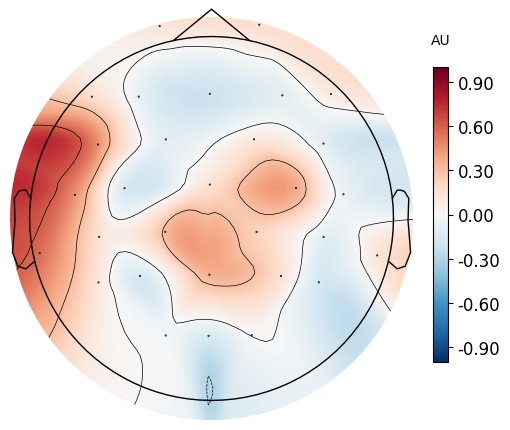

In [32]:
graph1=tfr_grand_averages['Critical/Amb/Erg'].plot_topomap(
    tmin=0.3,
    tmax=0.45,
    fmin=15,
    fmax=20,
    vlim=(-1.0, 1.0),
    cbar_fmt='%.2f',
    size=5
    )

In [33]:
#@title Ｂｌａｃｋ　Ｂｏｘ (＞Ｅｘｐｌｏｒｅ)


def plot_topomaptfr(condition, tmin, tmax, fmin, fmax, cmap):
    show_names=False


    if toggle_color.value == 'gnuplot2':
      show_names=True
    else:
      show_names=False
    obj = tfr_grand_averages[condition]
    obj.plot_topomap(
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        size=5,
        res=260,
        vlim=(-1,1),
        cbar_fmt='%.2f',
        cmap=cmap,
        show_names=show_names
        )
toggle_condition=ipywidgets.ToggleButtons(
    options=['Critical/Amb/Erg', 'Critical/Amb/Abs', 'Critical/Unamb/Erg', 'Critical/Unamb/Abs'],
    description='Condición:',
    disabled=False,
    button_style='',
    style={'button_width':'10em'},
)
label = ipywidgets.HTML(
    value="<div style='font-size:18px; text-align:left;'>Exploremos qué sucede en cada condición:</div>"
)
t0 = ipywidgets.FloatSlider(
    value=0,    # (inicio, fin)
    min=0.0,
    max=1.0,
    step=0.01,
    description='Tiempo (s)',   # ojo con la unidad
    #readout_format='.2f',
    continuous_update=False,
)
t1 = ipywidgets.FloatSlider(
    value=0.2,    # (inicio, fin)
    min=0.0,
    max=1.0,
    step=0.01,
    description='Tiempo (s)',   # ojo con la unidad
    #readout_format='.2f',
    continuous_update=False,
)

f0_slider = ipywidgets.FloatSlider(
    value=12, min=5, max=40, step=0.05, description='Frecuencia mínima (Hz)'
)

f1_slider = ipywidgets.FloatSlider(
    value=20, min=7, max=40, step=0.05, description='Frecuencia máxima (Hz)'
)


toggle_color=ipywidgets.ToggleButtons(
    options=[
        ('ｄｅｆａｕｌｔ', 'RdBu_r'),
        ('ｏｒ', 'seismic'),
        ('ｓｅｅ','hsv'),
        ('ＦＵＲＴＨＥＲ','gnuplot2'),
        ],
    description='？？:',
    disabled=False,
    button_style='',
    style={'button_width':'10em'},
)



plot_widget = ipywidgets.interactive(
    plot_topomaptfr,
    condition=toggle_condition,
    tmin=t0,
    tmax=t1,
    fmin=f0_slider,
    fmax=f1_slider,
    cmap=toggle_color,
)



ipywidgets.VBox([label, plot_widget])


<h2>Obtener datos del objeto<h2>


Tal como los objetos evokeds, nuestro objeto AverageTFR tiene el método`.to_data_frame`. Esto nos servirá para exportar los datos al formato de tabla.



<table>
  <tr><th colspan="2" align="left">Método: <strong>.to_data_frame</strong></strong>
  </strong>
  <br><br>
  Objeto mne.time_frequency.AverageTFR</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne.time_frequency.AverageTFR.to_data_frame"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>

<br>


<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Tabla de pandas dataframe.
</table>

In [34]:
tfr_dataframe=tfr_grand_averages['Critical/Amb/Erg'].to_data_frame()
display(tfr_dataframe)

,time,freq,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,...,CP6,P7,P3,Pz,P4,P8,O1,Oz,O2,TP10
0,-0.100,4.5,-0.505835,-0.247514,-0.682668,-0.243989,-0.253133,-0.636786,-0.525836,-0.668237,...,-0.310818,-0.560499,-0.693434,-0.610845,-0.484944,-0.575814,-0.622471,-0.552640,-0.624470,-0.317630
1,-0.052,4.5,-0.205660,-0.099051,-0.157210,-0.147264,-0.117141,-0.113206,-0.259742,-0.132578,...,-0.174764,-0.117382,-0.149780,-0.224360,-0.191783,-0.196120,-0.106678,-0.080906,-0.098449,0.007039
2,-0.004,4.5,0.204824,0.122793,0.263044,0.165492,0.191117,0.194786,0.151977,0.307387,...,0.198885,0.288507,0.310239,0.238500,0.278315,0.294215,0.250820,0.057484,0.255243,0.080562
3,0.044,4.5,0.544887,0.521485,0.584355,0.516881,0.458254,0.390799,0.780861,0.585318,...,0.489939,0.588845,0.629035,0.763402,0.512016,0.579946,0.629978,0.655069,0.396999,0.405304
4,0.092,4.5,0.821677,0.864335,0.692720,0.668135,0.631175,0.767065,1.081613,0.668220,...,0.593793,0.728968,0.776111,0.983865,0.513579,0.691286,0.840729,0.826701,0.484882,0.518721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,0.764,39.5,-0.899468,-0.341931,-0.034365,-0.096575,-0.257391,-0.479139,-0.255269,-0.346095,...,-0.143885,-0.244487,-0.313252,-0.336458,-0.404659,-0.530231,-0.876636,-0.497313,-0.297306,-0.120072
1629,0.812,39.5,-0.303026,-0.378920,-0.309616,-0.445581,-0.649973,-0.183900,-0.466808,-0.697082,...,-0.290193,0.009775,-0.259311,0.104220,-0.134347,-0.386760,-0.322167,-0.134726,-0.534127,-0.263672
1630,0.860,39.5,-0.390744,-0.795539,-0.424327,-0.309503,-0.417358,-0.490828,-0.575632,-0.602438,...,-0.066574,-0.174170,-0.224268,-0.280258,-0.285476,-0.257884,-0.408056,-0.762743,-0.579138,0.006082
1631,0.908,39.5,0.022863,-0.384366,-0.286654,-0.597313,-0.257170,-0.552000,-0.384086,0.086911,...,-0.051850,-0.074412,-0.347660,-0.250501,0.087614,-0.087425,-0.429844,-0.659328,-0.494534,-0.511621


In [35]:
#@title Ｂｌａｃｋ　Ｂｏｘ　(イラーケ。Ｉｒａｋｅ。)

import IPython


IPython.display.HTML('''
<div style="text-align:center;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/thankyou_ai.png"
       style="max-width:40%; height:auto; border-radius:10px;">
</div>
''')

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


Ｆｅｌｉｃｉｄａｄｅｓ！

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

Ｙ　ｍｕｃｈａｓ　ｇｒａｃｉａｓ。

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


**Referencias:**


> - Gorgolewski, K. J., Auer, T., Calhoun, V. D., Craddock, R. C., Das, S., Duff, E. P., ... & Poldrack, R. A. (2016). The brain imaging data structure, a format for organizing and describing outputs of neuroimaging experiments. Scientific data, 3(1), 1-9.

> - Isasi-Isasmendi, A., Sauppe, S., Andrews, C., Laka, I., Meyer, M., & Bickel, B. (2024). Incremental sentence processing is guided by a preference for agents: EEG evidence from Basque. Language, Cognition and Neuroscience, 39(1), 76-97.

> - Gramfort, A., Luessi, M., Larson, E., Engemann, D. A., Strohmeier, D., Brodbeck, C., ... & Hämäläinen, M. (2013). MEG and EEG data analysis with MNE-Python. Frontiers in Neuroinformatics, 7, 267.
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.17345411.svg)](https://doi.org/10.5281/zenodo.17345411).

>- Isasi-Isasmendi, A., Sauppe, S., Andrews, C., Laka, I., Meyer, M., & Bickel, B. (2024). Incremental sentence processing is guided by a preference for agents: EEG evidence from Basque. Language, Cognition and Neuroscience, 39(1), 76-97.

> - Jas, M., Engemann, D. A., Bekhti, Y., Raimondo, F., & Gramfort, A. (2017). Autoreject: Automated artifact rejection for MEG and EEG data. NeuroImage, 159, 417-429.

> - Jas, M., Engemann, D., Raimondo, F., Bekhti, Y., & Gramfort, A. (2016, June). Automated rejection and repair of bad trials in MEG/EEG. In 2016 international workshop on pattern recognition in neuroimaging (PRNI) (pp. 1-4). IEEE.

> - Appelhoff, S., Hurst, A. J., Lawrence, A., Li, A., Mantilla Ramos, Y. J., O'Reilly, C., ... & Dancker, J. (2022). PyPREP: A Python implementation of the preprocessing pipeline (PREP) for EEG data. Zenodo, 2. [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.16039994.svg)](https://doi.org/10.5281/zenodo.16039994)

> - Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K.-M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in Neuroinformatics, 9, 16. doi: 10.3389/fninf.2015.00016

> - Mendoza-Halliday, D., Major, A. J., Lee, N., Lichtenfeld, M. J., Carlson, B., Mitchell, B., ... & Bastos, A. M. (2024). A ubiquitous spectrolaminar motif of local field potential power across the primate cortex. Nature Neuroscience, 27(3), 547-560.

> - Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A., & Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software, 4:1896. DOI: 10.21105/joss.01896

> - Pernet, C. R., Appelhoff, S., Gorgolewski, K. J., Flandin, G., Phillips, C., Delorme, A., & Oostenveld, R. (2019). EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Scientific data, 6(1), 103.

> - Newman, A. J. Neural data science in python (2020). URL https://neuraldatascience.io/intro.html.

> - Li, A., Feitelberg, J., Saini, A. P., Höchenberger, R., & Scheltienne, M. (2022). MNE-ICALabel: Automatically annotating ICA components with ICLabel in Python. Journal of Open Source Software, 7(76), 4484.

> - Pion-Tonachini, L., Kreutz-Delgado, K., & Makeig, S. (2019). ICLabel: An automated electroencephalographic independent component classifier, dataset, and website. NeuroImage, 198, 181-197.

> - Winkler, I., Debener, S., Müller, K. R., & Tangermann, M. (2015, August). On the influence of high-pass filtering on ICA-based artifact reduction in EEG-ERP. In 2015 37th annual international conference of the IEEE engineering in medicine and biology society (EMBC) (pp. 4101-4105). IEEE.



Autores:

Daniel Falcón.  
Renato Paredes.